# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

In [40]:
# For Google Colab only:
from google.colab import drive
drive.mount('/content/drive')
google = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"

import sys
import numpy as np
sys.path.append(google)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
# data = np.load("data/data_gaze.npy")
data = np.load(google+"data/data_gaze.npy")

print(data.dtype)
print(data.shape)

## Deep Learning

In [41]:
import os
import datetime

import IPython
import IPython.display
import random
import numpy as np
from numpy import array, hstack
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from lists import list_str

tensorflow.version.VERSION

'2.8.0'

In [ ]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

In [ ]:
# Split a multivariate sequence into samples (modified from Brownlee 2018, p.156)
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        if i % (sampling_rate) == 0: # to remove redundancy in samples
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

Number of dyads: 2
num_train_samples per dyad: 174
num_val_samples per dyad: 58
num_test_samples per dyaed: 58
Length of samples: 348 116 116


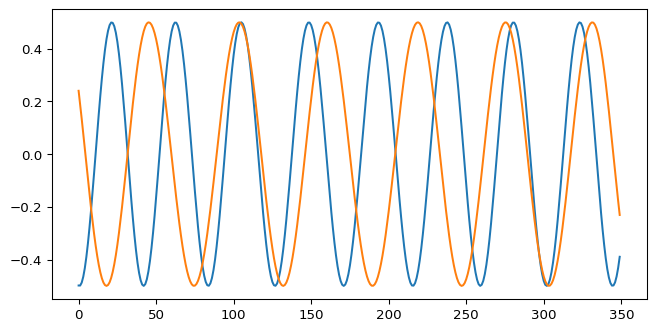

In [78]:
# Create samples
X_input_train = X_input_vali = X_input_test = np.empty((0, n_steps_in, 2))
y_output_train = y_output_vali = y_output_test = np.empty((0, n_steps_out, 2))

idx = list(range(len(list_str)))[::2] # for all dyads
# idx = [0] # for testing with only 1 dyad

for i in range(len(idx)):
        # define input sequence
        in_seq1 = data[idx[i]]
        in_seq2 = data[idx[i]+1]
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2))
        # covert into input/output
        X, y = split_sequences(dataset, n_steps_in, n_steps_out)
        # data split
        num_train_samples = int(0.6 * len(X))
        num_val_samples = int(0.2 * len(X))
        num_test_samples = len(X) - num_train_samples - num_val_samples
        # append data for multiple dyads
        X_input_train = np.append(X_input_train,X[:num_train_samples],axis=0)
        y_output_train = np.append(y_output_train,y[:num_train_samples],axis=0)
        X_input_vali = np.append(X_input_vali,X[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        y_output_vali = np.append(y_output_vali,y[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        X_input_test = np.append(X_input_test,X[(num_train_samples+num_val_samples):],axis=0)
        y_output_test = np.append(y_output_test,y[(num_train_samples+num_val_samples):],axis=0)

n_features = X.shape[2]

fig = plt.figure(figsize=(8,4), dpi=96)
example = np.append(X_input_train[14,:,0], y_output_train[14,:,0])
example2 = np.append(X_input_train[14,:,1], y_output_train[14,:,1])
plt.plot(example)
plt.plot(example2)

print("Number of dyads:", max(idx))
print("num_train_samples per dyad:", num_train_samples)
print("num_val_samples per dyad:", num_val_samples)
print("num_test_samples per dyad:", num_test_samples)
print("Length of samples:", len(X_input_train), len(X_input_vali), len(X_input_test))

In [94]:
# Define seq2seq model with Loung attention
# Modified from Wieniawska 2020 
# (https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)

# Input layer
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]))
output_train = Input(shape=(y_output_train.shape[1], y_output_train.shape[2]))

# Encoder LSTM
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

# Batch normalisation to avoid gradient explosion
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Decoder LSTM
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

# Attention layer
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

# Calculate context vector with batch normalisation
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

# Combine context vector with stacked hidden states of decoder for input to the last dense layer
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

# Dense layer with repeated weights
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

# Compile model
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 250, 100), dtype=tf.float32, name=None), name='lstm_10/transpose_1:0', description="created by layer 'lstm_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_10/while:4', description="created by layer 'lstm_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_10/while:5', description="created by layer 'lstm_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100), dtype=tf.float32, name=None), name='repeat_vector_5/Tile:0', description="created by layer 'repeat_vector_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100), dtype=tf.float32, name=None), name='lstm_11/transpose_1:0', description="created by layer 'lstm_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 250), dtype=tf.float32, name=None), name='activation_2/Softmax:0', description="created by layer 'activation_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 10

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


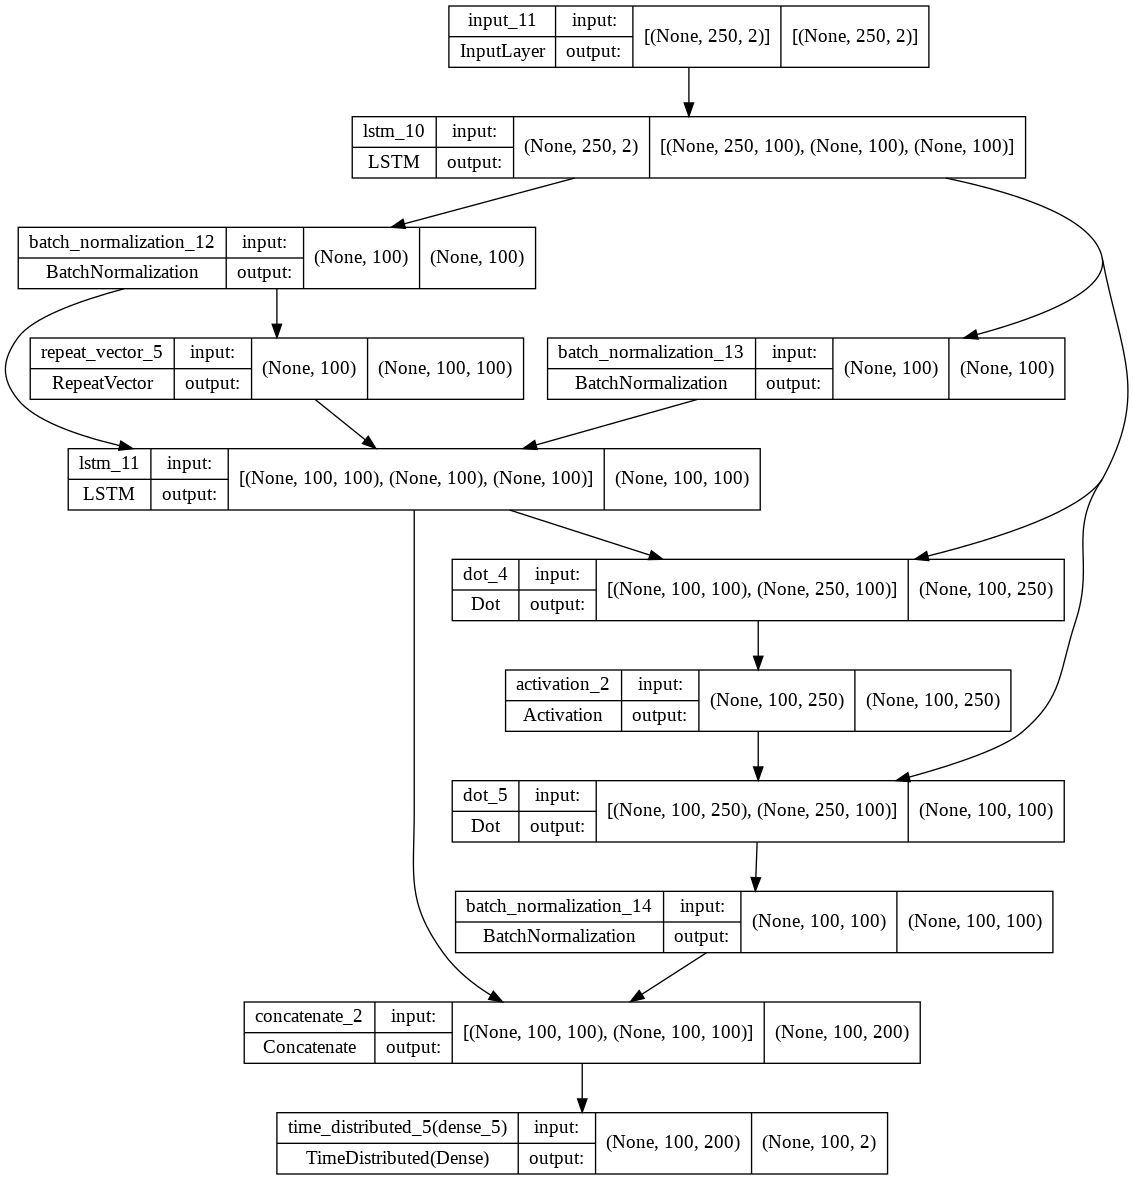

In [95]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [97]:
# Fit model
epc = 300
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train, y_output_train,  validation_data=(X_input_vali,y_output_vali), 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=64, shuffle = False)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq_loung.h5')

Epoch 1/300
6/6 [==============================] - 4s 637ms/step - loss: 0.1170 - mae: 0.3017 - val_loss: 0.1121 - val_mae: 0.2960
Epoch 2/300
6/6 [==============================] - 4s 607ms/step - loss: 0.1157 - mae: 0.2993 - val_loss: 0.1111 - val_mae: 0.2937
Epoch 3/300
6/6 [==============================] - 4s 617ms/step - loss: 0.1152 - mae: 0.2979 - val_loss: 0.1095 - val_mae: 0.2905
Epoch 4/300
6/6 [==============================] - 4s 671ms/step - loss: 0.1135 - mae: 0.2947 - val_loss: 0.1098 - val_mae: 0.2892
Epoch 5/300
6/6 [==============================] - 4s 611ms/step - loss: 0.1120 - mae: 0.2919 - val_loss: 0.1070 - val_mae: 0.2844
Epoch 6/300
6/6 [==============================] - 4s 598ms/step - loss: 0.1115 - mae: 0.2904 - val_loss: 0.1052 - val_mae: 0.2810
Epoch 7/300
6/6 [==============================] - 4s 607ms/step - loss: 0.1087 - mae: 0.2861 - val_loss: 0.1024 - val_mae: 0.2759
Epoch 8/300
6/6 [==============================] - 4s 599ms/step - loss: 0.1077 - m

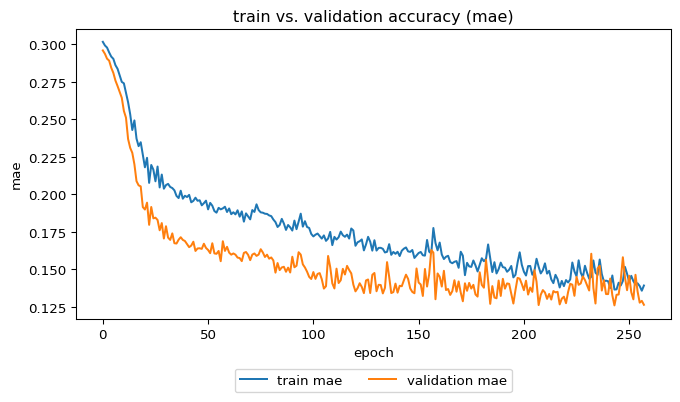

In [98]:
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [100]:
yhat_output_train = model.predict(X_input_train,batch_size=10)
yhat_output_test = model.predict(X_input_test,batch_size=10)
print(yhat_output_train.shape, yhat_output_test.shape)
print(y_output_train.shape, y_output_test.shape)

(348, 100, 2) (116, 100, 2)
(348, 100, 2) (116, 100, 2)


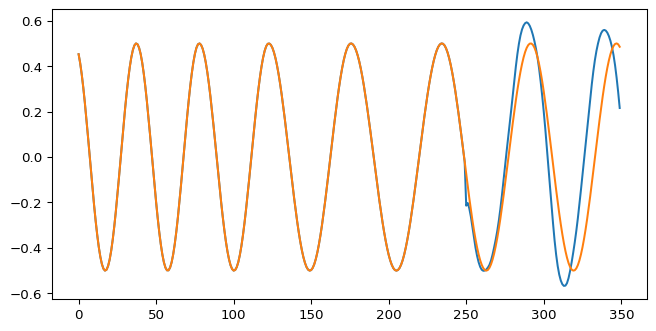

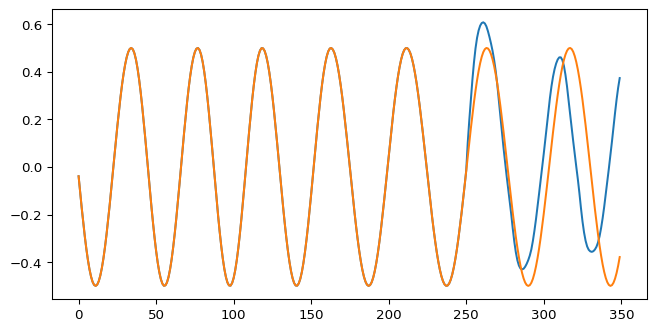

In [115]:
# Graphical demonstration
trial = 55
person = 1

# demonstrate training

train_hat = np.append(X_input_train[trial,:,person],yhat_output_train[trial,:,person])
train = np.append(X_input_train[trial,:,person],y_output_train[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(1)
plt.plot(train_hat)
plt.plot(train)

# demonstrate prediction

test_hat = np.append(X_input_test[trial,:,person],yhat_output_test[trial,:,person])
test = np.append(X_input_test[trial,:,person],y_output_test[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(2)

plt.plot(test_hat)
plt.plot(test)

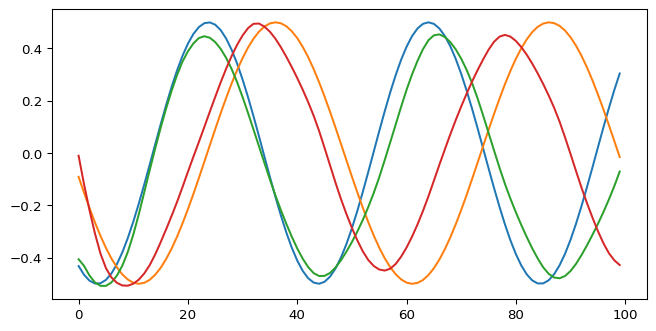

In [102]:
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(y_output_test[1])
plt.plot(yhat_output_test[1])

In [103]:
data_final = {
  "train_pred": yhat_output_train,
  "train_true": y_output_train,
  "test_pred": yhat_output_test,
  "test_true": y_output_test
}

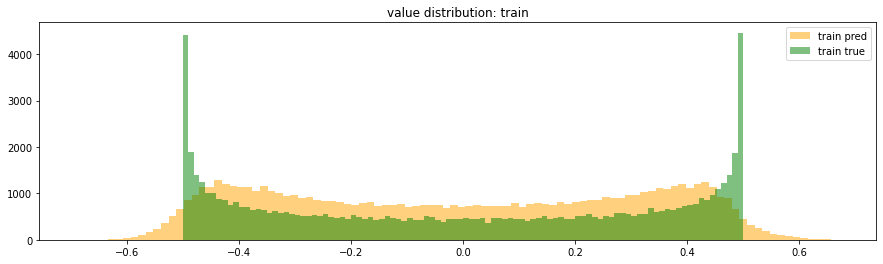

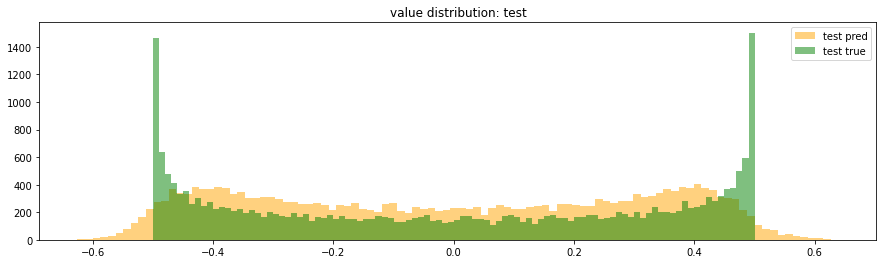

In [104]:
# Plot value distribution
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

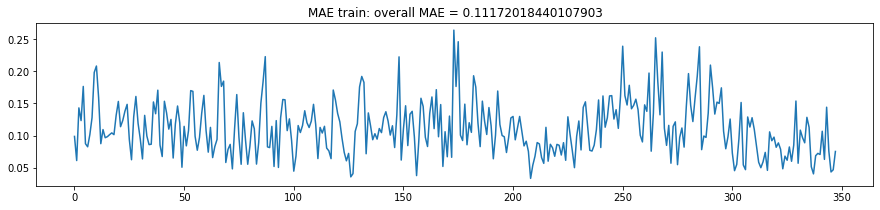

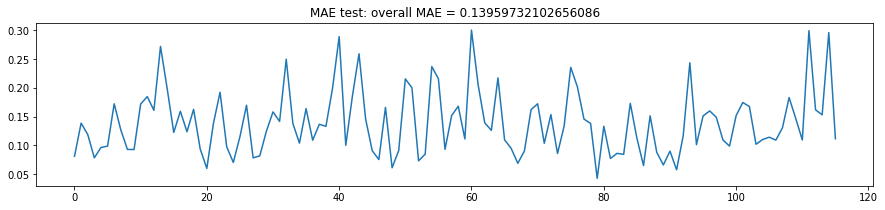

In [105]:
# plot MAE of all samples in time order, to see if there is clear pattern (which means more training is needed)
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

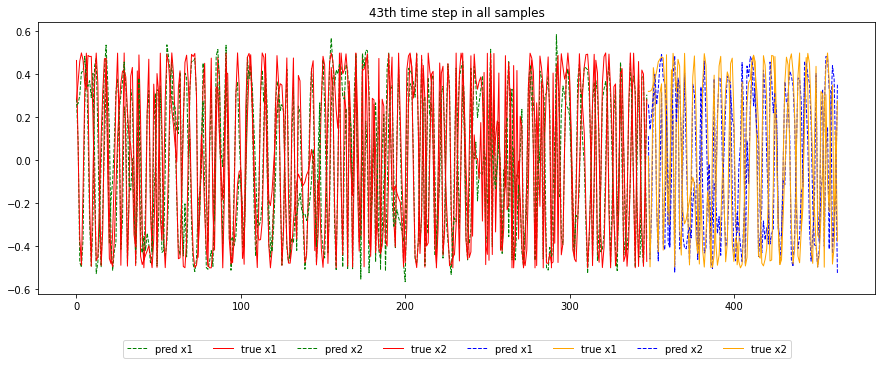

In [106]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

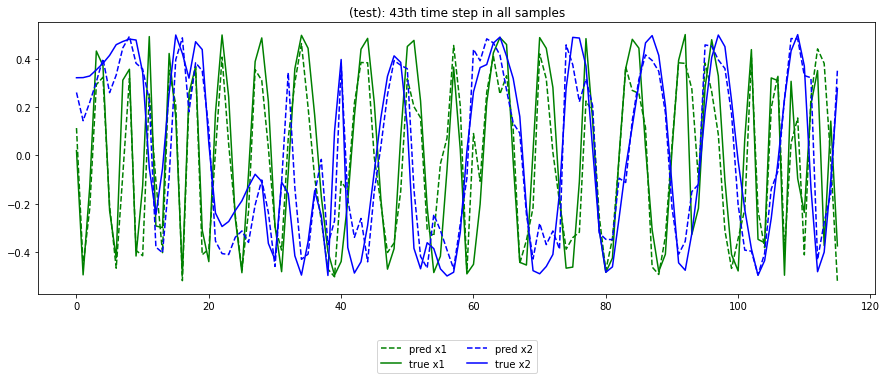

In [107]:
# Check the nth prediction of each time step
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [108]:
# Evaluate the model on the test data using evaluate`
print("Evaluate on test data")
results = model.evaluate(X_input_test, y_output_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 100ms/step - loss: 0.0385 - mae: 0.1396
test loss, test acc: [0.038529135286808014, 0.1395973116159439]
